# Server-Side Coexpression Analysis

This notebook demonstrates how to use the Malva coexpression API to identify
correlated genes, visualise metacell UMAP projections, and explore GO
enrichment — all computed server-side without needing scanpy locally.

## 1. Setup

Connect to the Malva API. If you have configured your token via
`malva_client config`, no arguments are needed.

In [1]:
from malva_client import MalvaClient

client = MalvaClient("https://malva.mdc-berlin.de", "uMqFKR2hkO8mNvGaqc0dol6SkqiDBEze0tCuvIot4qE")

INFO:malva_client.client:Connected to Malva API: healthy
INFO:malva_client.client:Authenticated successfully: free account


## 2. Discover Datasets

Browse the dataset hierarchy to find a dataset ID for coexpression analysis.

In [2]:
hierarchy = client.get_datasets_hierarchy()
client.print_dict_summary(hierarchy)

datasets: [{'cell_count': 52391470.0, 'dataset_id': 'default', 'description': 'All available samples', 'kmer_size': 64, 'name': 'Default Dataset', 'organism': 'Multiple', 'restricted': False, 'studies': [{'diseases': ['systemic lupus erythematosus'], 'laboratory': 'Unknown', 'organisms': ['Homo sapiens'], 'organs': ['blood'], 'sample_count': 269, 'study_name': 'Single-cellRNA-seqrevealscelltype-specificmolecula', 'study_title': 'Single-cell RNA-seq reveals cell type-specific molecular and genetic associations to lupus', 'total_cells': 5980942.0}, {'diseases': ['Lewy body dementia', 'Parkinson disease', 'dementia', 'normal'], 'laboratory': 'Genetics and Genomic Sciences', 'organisms': ['Homo sapiens'], 'organs': ['brain'], 'sample_count': 355, 'study_name': 'AtlasOfSubstantiaNigraInPD', 'study_title': "Single-Cell Transcriptomics of Human Substantia Nigra in Parkinson's Disease", 'total_cells': 4943983.0}, {'diseases': ['normal'], 'laboratory': 'Unknown', 'organisms': ['Homo sapiens'], 

## 3. Load UMAP Coordinates

Fetch the base UMAP embedding for a dataset. Replace `"DATASET_ID"`
with a dataset from the hierarchy above.

In [7]:
DATASET_ID = "Human_Cell_Atlas"  # <-- replace with your dataset

umap = client.get_umap_coordinates(DATASET_ID)
umap.to_dataframe().head()

,x,y,n_cells
0,5.019366,5.303446,4
1,4.458183,4.992155,3
2,4.259455,6.150664,2
3,3.423040,0.688364,56
4,4.574430,0.048661,42


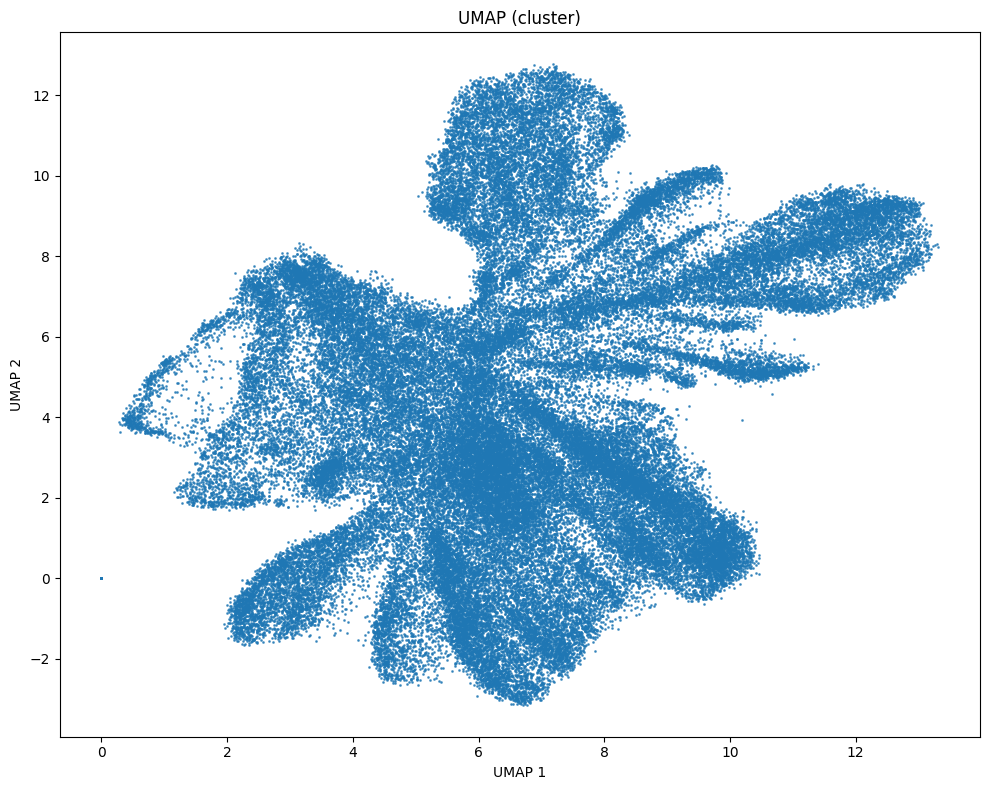

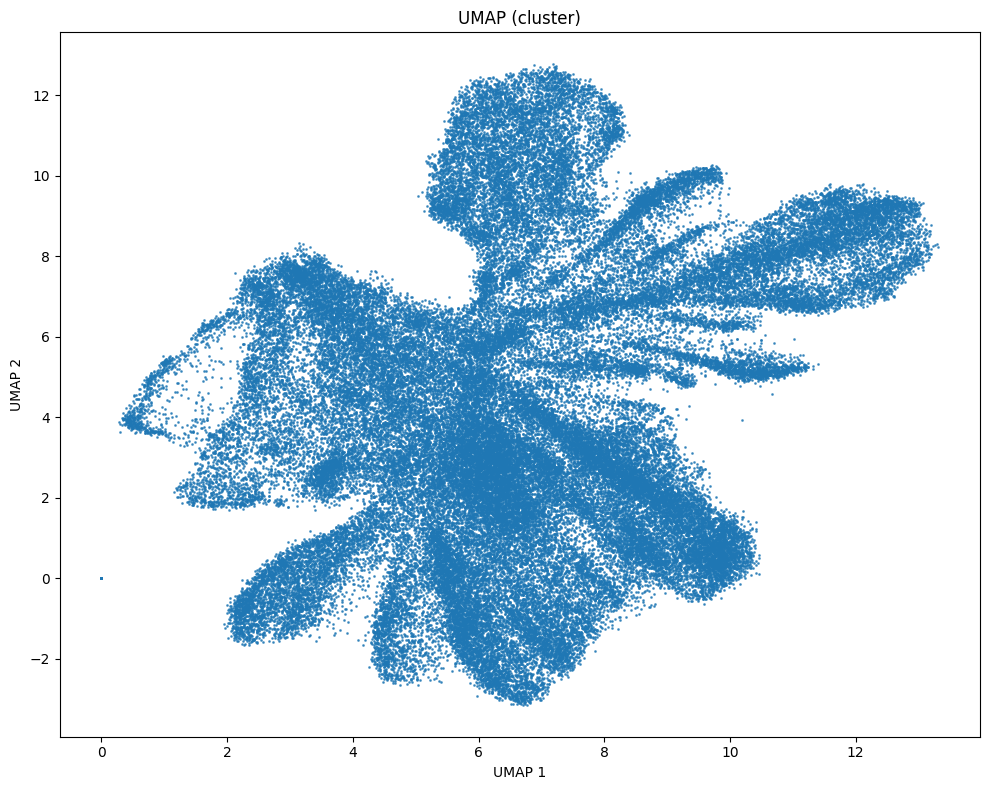

In [8]:
umap.plot(color_by='cluster')

## 4. Search for a Gene

Run a standard gene search and inspect the result.

In [4]:
result = client.search("FOXP3")
print(result)

INFO:malva_client.client:Search completed with job ID: 6839a89e-cfe1-497f-a738-2712cbefd21c


🔬 Malva Search Results
📊 Total cells: 53,582
📊 Sample/cell_type combinations: 12209
🧬 Genes/sequences: 1
🧪 Samples: 4324
🔬 Cell types: 241
📈 Expression range: 0.002 - 6.704
📊 Mean expression: 0.858

ℹ️  Basic expression data only
💡 Run .enrich_with_metadata() to add sample metadata for filtering by:
   • Organ, disease, species
   • Study, laboratory, protocol
   • Age, sex, development stage

🔍 Available methods:
   • .filter_by(organ='brain', disease='normal')
   • .aggregate_by('cell_type')
   • .plot_expression_by('organ')
   • .available_filter_fields()


## 5. Run Coexpression Analysis

Pass the search job ID and dataset to the coexpression API. This returns
correlated genes, UMAP scores, GO enrichment, cell-type enrichment, and
tissue breakdown — all computed on the server.

In [ ]:
coexpr = client.get_coexpression(result.job_id, DATASET_ID)
print(coexpr)

CoexpressionResult(dataset='Human_Cell_Atlas', genes=100, query_cells=53552, metacells=13324, go_terms=141)


## 6. UMAP with Expression Scores

Colour the UMAP by the fraction of cells expressing the queried gene.

In [10]:
coexpr.plot_umap(color_by='positive_fraction')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7b1b4d7c9bc0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7b1b4d5fd120> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [30]:
import matplotlib.pyplot as plt

color_by = 'positive_fraction'
point_size = None
cmap = 'magma'
figsize = (10, 8)

df = coexpr.scores_to_dataframe()

In [40]:
import pandas as pd
import numpy as np

if pd.api.types.is_any_real_numeric_dtype(df['cluster']):
    df = df.sort_values(by=color_by, ascending=True)

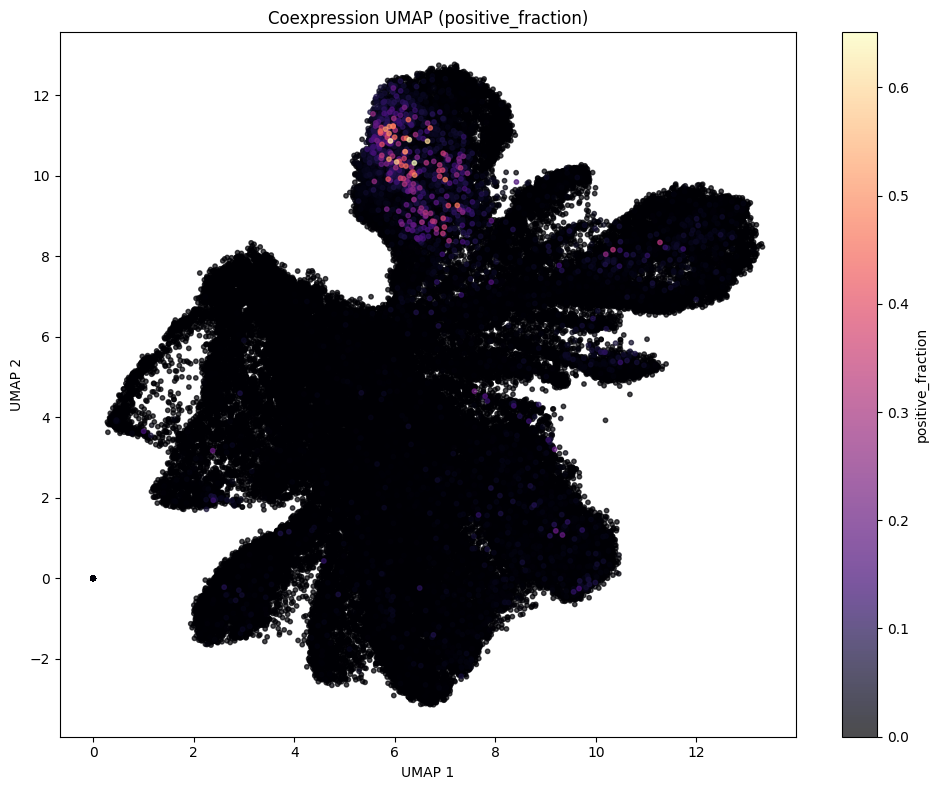

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))

if point_size is None:
    point_size = max(10, 200 / (len(df) ** 0.5))

x_col = 'umap_x' if 'umap_x' in df.columns else df.columns[0]
y_col = 'umap_y' if 'umap_y' in df.columns else df.columns[1]

if color_by in df.columns:
    scatter = ax.scatter(df[x_col], df[y_col], c=df[color_by],
                            s=point_size, cmap=cmap, alpha=0.7)
    plt.colorbar(scatter, ax=ax, label=color_by)
else:
    ax.scatter(df[x_col], df[y_col], s=point_size, alpha=0.7)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title(f'Coexpression UMAP ({color_by})')
plt.tight_layout()

## 7. Correlated Genes

Inspect the most strongly correlated genes.

In [ ]:
genes_df = coexpr.genes_to_dataframe()
genes_df.head(20)

In [ ]:
coexpr.plot_top_genes(n=20)

## 8. GO Enrichment

Explore Gene Ontology enrichment for the correlated gene set.

In [ ]:
go_df = coexpr.go_to_dataframe()
go_df.head(10)

In [ ]:
coexpr.plot_go_enrichment(n=10)

## 9. Cell Type & Tissue Breakdown

See which cell types and tissues are enriched for the query.

In [ ]:
coexpr.cell_type_enrichment_to_dataframe()

In [ ]:
coexpr.tissue_breakdown_to_dataframe()

## 10. Lightweight Query (Genes Only)

If you only need the correlated gene list (no UMAP scores, no GO), use
the lightweight endpoint for a faster response.

In [ ]:
quick = client.get_coexpression_genes(result.job_id, DATASET_ID)
quick.get_top_genes(5)

## 11. Compare Two Genes

Search for a second gene and compare their correlated gene sets.

In [ ]:
result_cd4 = client.search("CD4")
coexpr_cd4 = client.get_coexpression(result_cd4.job_id, DATASET_ID)

foxp3_genes = set(coexpr.get_top_genes(50))
cd4_genes = set(coexpr_cd4.get_top_genes(50))

shared = foxp3_genes & cd4_genes
print(f"Shared correlated genes (top 50): {len(shared)}")
print(sorted(shared))

## Summary

In this notebook we:

1. Loaded UMAP coordinates for a dataset
2. Ran a full server-side coexpression analysis
3. Visualised the UMAP coloured by expression scores
4. Explored correlated genes and GO enrichment
5. Inspected cell-type and tissue breakdown
6. Used the lightweight genes-only endpoint
7. Compared correlated gene sets between two queries

All analysis was done server-side — no local single-cell processing was
required.